## Collaborative filtering - Model based (Matrix Factorization)

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
path = "./movielens/movielens100k/"
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), index_col = 'userId', encoding='utf-8').reset_index()

In [4]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=123)

print(train_df.shape)
print(test_df.shape)

(80003, 4)
(20001, 4)


In [5]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

### Matrix factorization (SVD)

In [7]:
def get_svd(s_matrix, k=300):
    u, s, vh = np.linalg.svd(s_matrix.transpose())
    S = s[:k] * np.identity(k, np.float64)
    T = u[:,:k]
    Dt = vh[:k,:]

    item_factors = np.transpose(np.matmul(S, Dt))
    user_factors = np.transpose(T)

    return item_factors, user_factors

In [8]:
# filled average movie rating 
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

In [9]:
print(item_factors.shape)
print(user_factors.shape)

(8410, 300)
(300, 671)


In [10]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
1,3.966821,3.304887,3.150009,2.568517,3.368523,3.935357,3.220799,3.289031,3.152533,3.445781,...,2.500275,0.500055,3.000330,1.000110,1.500165,5.000550,4.500495,5.000550,3.000330,5.000550
2,3.962305,3.386131,3.153310,2.551842,3.208574,3.949514,3.193487,3.228757,3.179229,3.747424,...,2.500059,0.500012,3.000071,1.000024,1.500036,5.000118,4.500107,5.000118,3.000071,5.000118
3,3.864615,3.513745,3.238601,2.533615,3.227101,3.826269,3.199166,3.290263,3.186629,3.484503,...,2.499602,0.499920,2.999522,0.999841,1.499761,4.999204,4.499284,4.999204,2.999522,4.999204
4,3.912208,3.391451,3.137609,2.588494,3.319791,3.890230,3.197622,3.344723,3.150636,3.952209,...,2.499992,0.499998,2.999990,0.999997,1.499995,4.999983,4.499985,4.999983,2.999990,4.999983
5,3.864681,3.574060,4.031263,2.586854,3.380973,3.693254,3.101154,3.294792,3.220722,3.475165,...,2.499621,0.499924,2.999545,0.999848,1.499773,4.999242,4.499318,4.999242,2.999545,4.999242


In [11]:
# filled average user rating 
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

In [12]:
print(item_factors.shape)
print(user_factors.shape)

(8410, 300)
(300, 671)


In [13]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
1,2.366435,2.313420,2.436901,2.378410,2.380757,2.377249,2.386754,2.376033,2.381921,2.354715,...,2.381098,2.383131,2.383605,2.382094,2.382163,2.382975,2.378362,2.383582,2.381686,2.384611
2,3.436537,3.411618,3.409841,3.406400,3.399702,3.642035,3.347144,3.434613,3.454782,3.878186,...,3.491915,3.489365,3.492014,3.493339,3.492933,3.490642,3.491129,3.484625,3.495699,3.491600
3,3.493819,3.735619,3.551900,3.590684,3.534629,3.588045,3.621115,3.554101,3.624583,3.683466,...,3.570105,3.570043,3.570494,3.573144,3.572251,3.565702,3.567453,3.578814,3.564857,3.569159
4,4.349558,4.346539,4.441944,4.375084,4.387059,4.390737,4.431066,4.386004,4.394200,3.865731,...,4.388319,4.389959,4.388693,4.389374,4.389152,4.387696,4.388034,4.392103,4.386599,4.388925
5,3.890137,3.951271,4.017090,3.956674,3.916179,3.813446,3.952294,3.959433,3.945590,4.103411,...,3.943673,3.954294,3.944152,3.940529,3.941565,3.943302,3.945377,3.931016,3.951734,3.945831


In [14]:
item_pred_df = movie_prediction_result_df.stack().reset_index() 
item_pred_df.columns = ['userId','movieId','pred_ratings']
item_pred_df.head()

,userId,movieId,pred_ratings
0,1,1,3.966821
1,1,2,3.304887
2,1,3,3.150009
3,1,4,2.568517
4,1,5,3.368523


In [15]:
user_pred_df = user_prediction_result_df.stack().reset_index() 
user_pred_df.columns = ['userId','movieId','pred_ratings']
user_pred_df.head()

,userId,movieId,pred_ratings
0,1,1,2.366435
1,1,2,2.313420
2,1,3,2.436901
3,1,4,2.378410
4,1,5,2.380757


In [16]:
test_df = test_df.reset_index()
user_based_result = pd.merge(test_df, user_pred_df, on=['userId','movieId'], how='left')
item_based_result = pd.merge(test_df, item_pred_df, on=['userId','movieId'], how='left')

In [17]:
user_based_result = user_based_result.dropna() 
item_based_result = item_based_result.dropna()

In [18]:
print('filled average user rating ',sqrt(mean_squared_error(user_based_result['rating'].values, user_based_result['pred_ratings'].values)))
print('filled average item rating ',sqrt(mean_squared_error(item_based_result['rating'].values, item_based_result['pred_ratings'].values)))

filled average user rating  0.9663666141482012
filled average item rating  0.9922195476811708


In [19]:
# define evaluation function
def eval_pred_result(prediction_full_matrix):
    stack_results = prediction_full_matrix.stack().reset_index()
    stack_results.columns = ['userId','movieId','pred_ratings']
    result_df = pd.merge(test_df, stack_results, on=['userId','movieId'], how='left').dropna()
    rmse = sqrt(mean_squared_error(result_df['rating'].values, result_df['pred_ratings'].values))
    return result_df, rmse

### Expriments on different k value

In [20]:
def search_best_k(sparse_matrix, min_k = 20, max_k = 100):
    range_k = np.arange(min_k, max_k, 10)
    eval_result_df = pd.DataFrame(columns=['rmse'], index=range_k)
    for k in tqdm(range_k):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        k_results_matrix = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values).transpose()
        pred_df, rmse_ = eval_pred_result(k_results_matrix)
        eval_result_df.loc[k, 'rmse'] = rmse_
        best_pred_df = pred_df

        if k > min_k:
            if eval_result_df.loc[k-10, 'rmse'] < rmse_:
                best_pred_df = pred_df

    return best_pred_df, eval_result_df

In [21]:
best_pred_df, eval_result_df = search_best_k(sparse_matrix_withmovie, min_k = 20, max_k = 100)

/var/folders/1l/w3vzbf215cs4ll30rh71l7wr6ghggx/T/ipykernel_6191/3039461911.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range_k):


  0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
eval_result_df

,rmse
20,0.973615
30,0.97525
40,0.97561
50,0.976408
60,0.97742
70,0.978807
80,0.980113
90,0.980995


In [23]:
best_pred_df.head()

,index,userId,movieId,rating,timestamp,pred_ratings
0,4241,23,1625,4.5,1148671498,4.090757
1,84223,564,2801,3.0,974716060,4.509458
2,99408,665,1541,3.0,995232789,2.900207
3,85520,574,49530,4.0,1232810927,4.055198
4,67363,472,841,4.0,1006929182,3.713173


### Surprise package

In [29]:
from surprise import Reader, Dataset, SVDpp, BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy

In [25]:
ratings_df['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [26]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=123)

In [27]:
model = SVDpp()
model.fit(train_set)

In [28]:
predictions = model.test(test_set)
rmse = accuracy.rmse(predictions)
print('RMSE (SVD++) ::', rmse)

RMSE: 0.8875
RMSE (SVD++) :: 0.8874896245401949


In [30]:
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
model2 = BaselineOnly(bsl_options)
model2.fit(train_set)

Estimating biases using als...


In [31]:
predictions = model2.test(test_set)
rmse = accuracy.rmse(predictions)
print('RMSE (ALS) ::', rmse)

RMSE: 0.8866
RMSE (ALS) :: 0.886561635531417


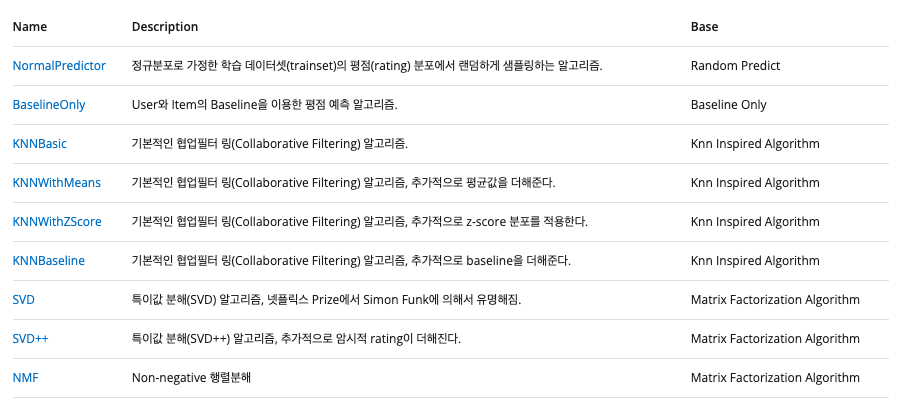
(출처 : https://danthetech.netlify.app/DataScience/how-does-recommendation-algorithms-work-using-surpriselib)